# Simulation of Other Methods

## 1. Graph System Identification (GSI) from paper [Graph Learning From Filtered Signals: Graph System and Diffusion Kernel Identification](https://arxiv.org/pdf/1803.02553.pdf)

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import scipy.io

import os
import sys
sys.path.append('/Users/apple/Desktop/graph_learning/FilterLearning/src')

from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import f1_score

import generators as gen
import optimize as opt
import helpers as hel
import pickle as pkl
from NNet import NNet
from networkx.generators.community import stochastic_block_model


%load_ext autoreload
%autoreload 2

In [2]:
os.getcwd()

'/Users/apple/Desktop/graph_learning/FilterLearning/examples'

In [3]:
def gen_samples(L, n_samples=500):
    """Reproducibly generates 500 samples from L."""
    if type(L) is not torch.Tensor:
        L = torch.Tensor(L)
    
    samples = gen.gen_white_noise(n_samples, L.shape[0], random_state=None)
    return samples

# generate graphs
def generate_L_sbm(nnodes=10, p_in=.8, p_out=.1, seed=42, n_blocks=2):
    """generates Laplacian of stochastic block model with 2 clusters, with nnodes."""
    if n_blocks==2:
        G = stochastic_block_model([nnodes//2,nnodes//2],[[p_in,p_out],[p_out,p_in]], seed=seed)
        A = nx.adjacency_matrix(G).todense()
        L = nx.laplacian_matrix(G).todense()  
    else:
        prob_matrix = np.eye(n_blocks)*(p_in-p_out) + p_out
        G = stochastic_block_model([nnodes//n_blocks]*n_blocks, prob_matrix, seed=seed)  
        A = nx.adjacency_matrix(G).todense()          
        L = nx.laplacian_matrix(G).todense()
    samples = gen_samples(L,n_samples=500)
    return  L#,samples.squeeze().tolist(), A

def create_multiple_graphs(n_graphs=20, **kwargs):
    return [generate_L_sbm(seed=i, **kwargs) for i in range(n_graphs)]

def to_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pkl.dump(obj, f)
        
def from_pickle(filename):
    with open(filename, 'rb') as f:
        return pkl.load(f)

In [4]:
Ls_30 = create_multiple_graphs(20, nnodes=45, p_in=.3, p_out=.1, n_blocks=3)
# Gs_30 = [i[0] for i in res_30]
# As_30 = [i[2] for i in res_30]
# Ls_30 = [i[0] for i in res_30]
# samples_30 = [i[1] for i in res_30]


to_pickle(Ls_30, 'GSI/data/Ls_30.pkl')
# to_pickle(As_30, 'GSI/data/As_30.pkl')
# # to_pickle(Gs_30, 'GSI/data/Gs_30.pkl')
# to_pickle(samples_30, 'GSI/data/samples_30.pkl')

# scipy.io.savemat('GSI/mat_files/As_30.mat', mdict={'As': As_30})
# # scipy.io.savemat('GSI/mat_files/Gs_30.mat', mdict={'Gs': Gs_30})
scipy.io.savemat('GSI/mat_files/Ls_30.mat', mdict={'Ls': Ls_30})
# scipy.io.savemat('GSI/mat_files/samples_30.mat', mdict={'samples': samples_30})


Ls_50 = create_multiple_graphs(20, nnodes=45, p_in=.5, p_out=.1, n_blocks=3)
# # Gs_50 = [i[0] for i in res_50]
# As_50 = [i[2]  for i in res_50]
# Ls_50 = [i[0] for i in res_50]
# samples_50 = [i[1] for i in res_50]

to_pickle(Ls_50, 'GSI/data/Ls_50.pkl')
# to_pickle(As_50, 'GSI/data/As_50.pkl')
# # to_pickle(Gs_50, 'GSI/data/Gs_50.pkl')
# to_pickle(samples_50, 'GSI/data/samples_50.pkl')

# scipy.io.savemat('GSI/mat_files/As_50.mat', mdict={'As': As_50})
# # scipy.io.savemat('GSI/mat_files/Gs_50.mat', mdict={'Gs': Gs_50})
scipy.io.savemat('GSI/mat_files/Ls_50.mat', mdict={'Ls': Ls_50})
# scipy.io.savemat('GSI/mat_files/samples_50.mat', mdict={'samples': samples_50})


Ls_70 = create_multiple_graphs(20, nnodes=45, p_in=.7, p_out=.1, n_blocks=3)
# # Gs_70 = [i[0] for i in res_70]
# As_70 = [i[2] for i in res_70]
# Ls_70 = [i[0] for i in res_70]
# samples_70 = [i[1] for i in res_70]

to_pickle(Ls_70, 'GSI/data/Ls_70.pkl')
# to_pickle(As_70, 'GSI/data/As_70.pkl')
# # to_pickle(Gs_70, 'GSI/data/Gs_70.pkl')
# to_pickle(samples_70, 'GSI/data/samples_70.pkl')

# scipy.io.savemat('GSI/mat_files/As_70.mat', mdict={'As': As_70})
# # scipy.io.savemat('GSI/mat_files/Gs_70.mat', mdict={'Gs': Gs_70})
scipy.io.savemat('GSI/mat_files/Ls_70.mat', mdict={'Ls': Ls_70})
# scipy.io.savemat('GSI/mat_files/samples_70.mat', mdict={'samples': samples_70})

In [5]:
def sample(L, ker, n_samples=500):
    """Reproducibly generates 500 samples from L using kernel ker, then 
    imputes a graph using the imputer. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    
    samples = gen.gen_and_filter(L, n_samples, ker=ker, seed=42)
    return samples.squeeze().tolist() #imputer(samples)


def simulate(Ls, ker, verbose=True):
    """For every L in Ls, generates samples with ker and imputes the graph
    using the imputer method. Imputer is a function that
    takes samples and returns an adjacency matrix."""
    out = []
    for i, L in enumerate(Ls):
        if verbose:
            print('\rGenerating sample {}'.format(i+1), end=' ')
        out.append(sample(L, ker))
    return out

def f1_scores(Ls, imps):
    """Calculates f1 scores between lists"""
    
    return [f1_score(np.asarray(L<0).flatten(), imp.flatten()) for L, imp in zip(Ls, imps)]

def process_all(savefile_prefix):
    kerlist = [gen.kernel_heat, gen.kernel_normal, 
               lambda x: gen.kernel_highpass(x, par=.5)]
    kernames = ['heat', 'norm', 'high']
    
    Lslist = [Ls_30, Ls_50, Ls_70]
    Lsnames = ['30', '50', '70']
    
    for ker, kername in zip(kerlist, kernames):
        print('Kernel:', kername)
        
        for Ls, Lsname in zip(Lslist, Lsnames):
            print('Ls:', Lsname)
            
            samples = simulate(Ls, ker)
            #f1 = f1_scores(Ls, imps)

            savefile_suffix = '_' + Lsname + '_' + kername + '.pkl'
            to_pickle(samples, savefile_prefix + Lsname + '_' + kername + '.pkl')
            scipy.io.savemat('GSI/mat_files/samples_'+ Lsname + '_' + kername + '.mat', mdict={'samples_' + kername: samples})

            #to_pickle(imps, savefile_prefix + savefile_suffix)
            #to_pickle(f1, savefile_prefix + '_f1' + savefile_suffix)
        

In [6]:
process_all('GSI/data/samples_')

Kernel: heat
Ls: 30
Generating sample 20 Ls: 50
Generating sample 20 Ls: 70
Generating sample 20 Kernel: norm
Ls: 30
Generating sample 20 Ls: 50
Generating sample 20 Ls: 70
Generating sample 20 Kernel: high
Ls: 30
Generating sample 20 Ls: 50
Generating sample 20 Ls: 70
Generating sample 20 

Use data saved in 'GSI/mat_files' and run algorithm in MATLAB. Then run the rest of this notebook. 

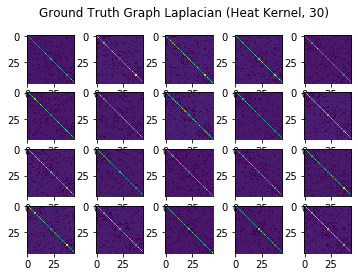

In [8]:
fig, axs = plt.subplots(4,5)
fig.suptitle('Ground Truth Graph Laplacian (30)')
k = 0
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(Ls_30[k])
        k+=1

In [10]:
Ls_30_heat_dict = scipy.io.loadmat('GSI/mat_files/Ls_30_heatkernel_GSI_res.mat')
Ls_30_heat_res = Ls_30_heat_dict['Ls_GSI_est']

Ls_50_heat_dict = scipy.io.loadmat('GSI/mat_files/Ls_50_heatkernel_GSI_res.mat')
Ls_50_heat_res = Ls_50_heat_dict['Ls_GSI_est']

Ls_70_heat_dict = scipy.io.loadmat('GSI/mat_files/Ls_70_heatkernel_GSI_res.mat')
Ls_70_heat_res = Ls_70_heat_dict['Ls_GSI_est']

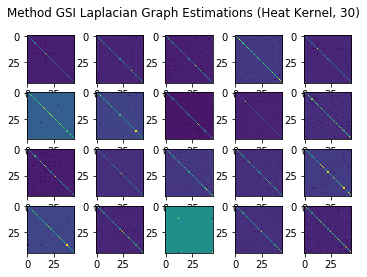

In [11]:
fig, axs = plt.subplots(4,5)
fig.suptitle('Method GSI Laplacian Graph Estimations (Heat Kernel, 30)')
k = 0
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(Ls_30_heat_res[k,:,:])
        k+=1

In [12]:
Ls_30_high_dict = scipy.io.loadmat('GSI/mat_files/Ls_30_highkernel_GSI_res.mat')
Ls_30_high_res = Ls_30_high_dict['Ls_GSI_est']

Ls_50_high_dict = scipy.io.loadmat('GSI/mat_files/Ls_50_highkernel_GSI_res.mat')
Ls_50_high_res = Ls_50_high_dict['Ls_GSI_est']

Ls_70_high_dict = scipy.io.loadmat('GSI/mat_files/Ls_70_highkernel_GSI_res.mat')
Ls_70_high_res = Ls_70_high_dict['Ls_GSI_est']

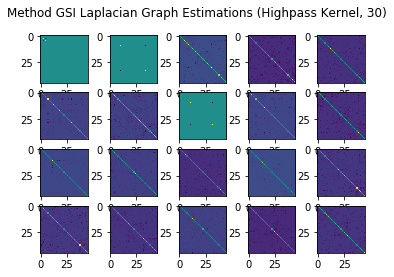

In [13]:
fig, axs = plt.subplots(4,5)
fig.suptitle('Method GSI Laplacian Graph Estimations (Highpass Kernel, 30)')
k = 0
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(Ls_30_high_res[k,:,:])
        k+=1

In [14]:
Ls_30_normal_dict = scipy.io.loadmat('GSI/mat_files/Ls_30_normalkernel_GSI_res.mat')
Ls_30_normal_res = Ls_30_normal_dict['Ls_GSI_est']

Ls_50_normal_dict = scipy.io.loadmat('GSI/mat_files/Ls_50_normalkernel_GSI_res.mat')
Ls_50_normal_res = Ls_50_normal_dict['Ls_GSI_est']

Ls_70_normal_dict = scipy.io.loadmat('GSI/mat_files/Ls_70_normalkernel_GSI_res.mat')
Ls_70_normal_res = Ls_70_normal_dict['Ls_GSI_est']

In [ ]:
fig, axs = plt.subplots(4,5)
fig.suptitle('Method GSI Laplacian Graph Estimations (Normal Kernel, 30)')
k = 0
for i in range(4):
    for j in range(5):
        axs[i, j].imshow(Ls_30_normal_res[k,:,:])
        k+=1

In [ ]:
kerlist = [gen.kernel_heat, gen.kernel_normal, 
            lambda x: gen.kernel_highpass(x, par=.5)]
kernames = ['heat', 'norm', 'high']

Lslist = [Ls_30, Ls_50, Ls_70]
Lsnames = ['30', '50', '70']

for ker, kername in zip(kerlist, kernames):
    print('Kernel:', kername)
    
    for Ls, Lsname in zip(Lslist, Lsnames):
        print('Ls:', Lsname)
        
        
        f1 = f1_scores(Ls, imps)

In [38]:

for i in range(20):
    print(f1_score(np.asarray(Ls_30[i]).flatten(), Ls_30_res[i,:,:].flatten()))


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

numpy.ndarray

## Plot our results to compare

In [ ]:
# from os import walk

# f = []
# for (dirpath, dirnames, filenames) in walk(mypath):
#     f.extend(filenames)
#     break
